In [1]:
!pip install tqdm
!pip install openpyxl
!pip install yfinance

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import glob
from datetime import datetime
from google.colab import drive
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
drive.mount('/content/drive')

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Mounted at /content/drive


#### LGB+feature engineering

In [2]:
import pandas as pd
import statsmodels.api as sm

def ts_sum(df, window):
    return df.rolling(window).sum()

def sma(df, window):
    return df.rolling(window).mean()

def ts_min(df, window):
    return df.rolling(window).min()

def ts_median(df, window):
    return df.rolling(window).median()

def ts_max(df, window):
    return df.rolling(window).max()

def delta(df, period):
    return df.diff(period)

def delay(df, period):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window):
    return df.rolling(window).apply(np.argmax) + 1

def ts_mean(df, window):
  return df.rolling(window).mean()

def zscore(df, window):
  return (df-df.rolling(window).mean())/df.rolling(window).std()

# def ts_regression(X, y):
#   return sm.OLS(y, sm.add_constant(X)).fit().params.iloc[1]
#ts_corr, ts_regression
# -(RANK(ts_corr(VWAP, VOLUME, 4)) *RANK(ts_corr(RANK(LOW), RANK(ts_mean(VOLUME,50)), 12)))

def ts_corr(df1, df2, window, method='pearson'):
  return df1.rolling(window).corr(df2)
  # aligned = pd.concat([df1, df2], axis=1, join='inner').dropna()

  # if window is None:
  #       # Full-period correlation
  #       return aligned.iloc[:, 0].corr(aligned.iloc[:, 1])
  # else:
  #       # Rolling window correlation
  #       return aligned.iloc[:, 0].rolling(window).corr(aligned.iloc[:, 1])



In [3]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']
        self.SDG_Mean = daily_info['SDG_Mean']
        self.STS_Mean = daily_info['STS_Mean']
        self.LTS_Mean = daily_info['LTS_Mean']
        self.SDG_STD_Mean = daily_info['SDG_STD_Mean']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))


        # alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        # alpha_dict['alpha_total_mv']= daily_info['total_mv']
        # alpha_dict['alpha_pb']= -1*daily_info['pb']
        # alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        # alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']

        # alpha_dict['alpha_vwap']= daily_info['vwap']
        # alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        alpha_dict['SDG_1'] = (self.SDG_Mean + self.STS_Mean + self.LTS_Mean) / 3
        alpha_dict['SDG_2'] = (self.SDG_Mean - sma(self.SDG_Mean, 30)) / self.SDG_STD_Mean
        alpha_dict['SDG_3'] = zscore(self.SDG_Mean, 10) + zscore(self.STS_Mean, 10) + zscore(self.LTS_Mean, 10)
        alpha_dict['SDG_4'] = ts_corr(self.SDG_Mean, self.STS_Mean, 10)
        alpha_dict['SDG_5'] = ts_corr(self.SDG_Mean, self.LTS_Mean, 10)
        alpha_dict['SDG_6'] = ts_corr(self.STS_Mean, self.LTS_Mean, 10)
        # alpha_dict['SDG_7'] = ts_regression(self.SDG_Mean, self.STS_Mean) + ts_regression(self.SDG_Mean, self.LTS_Mean) +ts_regression(self.SDG_Mean, self.LTS_Mean)
        alpha_dict['SDG_8'] = ts_corr(self.SDG_Mean, self.volume, 10)
        alpha_dict['SDG_9'] = ts_corr(self.STS_Mean, self.volume, 10)
        alpha_dict['SDG_10'] = ts_corr(self.LTS_Mean, self.volume, 10)
        alpha_dict['SDG_11'] = ts_mean(self.SDG_Mean, 30) + ts_mean(self.STS_Mean, 30) + ts_mean(self.LTS_Mean, 30)
        alpha_dict['SDG_12'] = ts_mean(self.SDG_Mean, 10) + ts_mean(self.SDG_Mean, 30) + ts_mean(self.SDG_Mean, 60)
        print('before 12 is ok\n')

        #m_minus = ts_mean(close,30)-ts_mean(close,10);
        # s_delta = (ts_arg_max(m_minus,10)-m_minus)/(ts_arg_max(m_minus,10)-ts_arg_min(m_minus,10));
        # PCY = 0.5*s_delta+0.5*ts_delay(s_delta,1);
        alpha_dict['alpha35'] = (self.SDG_Mean - sma(self.SDG_Mean, 30))
        alpha_dict['alpha36'] = (self.SDG_Mean - sma(self.SDG_Mean, 60))
        alpha_dict['alpha37'] = (self.SDG_Mean - sma(self.SDG_Mean, 120))
        m_minus = ts_mean(self.close,30)-ts_mean(self.close,10);
        s_delta = (ts_argmax(m_minus,10)-m_minus)/(ts_argmax(m_minus,10)-ts_min(m_minus,10));
        alpha_dict['alpha38'] = 0.5*s_delta+0.5*delay(s_delta,1);
        print('before 38 is ok\n')

        # log(ts_regression(ts_mean(volume,30)-ts_mean(volume,360),ts_mean(ts_mean(volume,30)-ts_mean(volume,360),16),300,lag=0,rettype=6))
        # -0.2*rank(close/ts_delay(close,10))
        alpha_dict['alpha39'] = -0.2*(self.close/delay(self.close,10))
        #log(ts_regression(close,ts_mean(close,16),300,lag=0,rettype=6))+0.2*ts_rank(operating_income/cap,252)
        # alpha_dict['alpha40'] = ts_regression(self.close,ts_mean(self.close,16))
        # alpha_dict['alpha41'] = ts_regression(ts_mean(self.amount, 10) - ts_mean(self.amount, 30), ts_mean(self.amount, 16))
        print('before 41 is ok\n')

        return alpha_dict


##### build training set

In [4]:
df = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/merge_SDG_price_497_companies.csv')
# df.head()
df.Timestamp = pd.to_datetime(df.Timestamp)
df.set_index('Timestamp', inplace=True)
# percentage change
df['Price_change'] = (df.groupby('Ticker')['Close'].transform(lambda x: x.pct_change().shift(-1)))*100
df.head()

,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,0.027248,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,0.027248,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,0.027248,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,0.027248,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,0.027248,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [5]:
df = df.reset_index()
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [6]:
df.columns

Index(['Timestamp', 'Ticker', 'ISIN', 'Company_Name', 'GICS Sector', 'SDG_1',
       'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5',
       ...
       'SDG_16_News_Volume', 'SDG_17_News_Volume', 'SDG_News_Volume_Mean',
       'Close', 'High', 'Low', 'Open', 'Volume', 'Amount', 'Price_change'],
      dtype='object', length=102)

In [7]:
df = df.drop_duplicates(['Ticker', 'Timestamp']).sort_values(['Ticker', 'Timestamp']).reset_index(drop=True)
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [8]:
df['open_up'] = df.groupby('Ticker')['Open'].shift(1)/df.groupby('Ticker')['Close'].shift(0)
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change,open_up
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070


In [9]:
# t close buy and (t+1) close sell
df['ret1'] = df.groupby('Ticker')['Close'].shift(-1)/df.groupby('Ticker')['Close'].shift(0)

# (t+1) open buy, (t+2) close sell
df['ret2'] = df.groupby('Ticker')['Close'].shift(-2)/df.groupby('Ticker')['Open'].shift(-1)

df['ret'] = df['ret2'].copy()
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [10]:
daily_info = {}
daily_info['open'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Open').fillna(df.Open.mean())
daily_info['close'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Close').fillna(df.Close.mean())
daily_info['high'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='High').fillna(df.High.mean())
daily_info['low'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Low').fillna(df.Low.mean())
daily_info['volume'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Volume').fillna(df.Volume.mean())
daily_info['amount'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Amount').fillna(df.Amount.mean())
daily_info['vwap'] = (daily_info['amount']*1000 / daily_info['volume']*100+1)
daily_info['SDG_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='SDG_Mean').fillna(df.SDG_Mean.mean()).fillna(df.SDG_Mean.mean())
daily_info['STS_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='STS_Mean').fillna(df.STS_Mean.mean()).fillna(df.STS_Mean.mean())
daily_info['LTS_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='LTS_Mean').fillna(df.LTS_Mean.mean()).fillna(df.LTS_Mean.mean())
daily_info['SDG_STD_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='SDG_STD_Mean').fillna(df.SDG_STD_Mean.mean()).fillna(df.SDG_STD_Mean.mean())

In [11]:
daily_info['LTS_Mean'].head()

Ticker,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,...,WYNN,XEL,XOM,XRAY,XYL,YUM,Z,ZBH,ZION,ZTS
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,...,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.226053,0.205903,0.205903,0.205903
2013-04-02,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,...,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.226053,0.205903,0.205903,0.205903
2013-04-03,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,...,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.226053,0.205903,0.205903,0.205903
2013-04-04,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,...,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.226053,0.205903,0.205903,0.205903
2013-04-05,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,...,0.205903,0.205903,0.205903,0.205903,0.205903,0.205903,0.226053,0.205903,0.205903,0.205903


In [12]:
daily_info['SDG_Mean'].head()

Ticker,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,...,WYNN,XEL,XOM,XRAY,XYL,YUM,Z,ZBH,ZION,ZTS
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.283179,0.283179,0.283179,0.283179,0.283179,0.283179,0.283179,0.283179,0.283179,0.283179,...,0.283179,-0.588235,-3.701540,0.283179,0.283179,-0.469087,0.322489,0.283179,-2.525850,0.283179
2013-04-02,4.885057,1.154250,0.283179,0.283179,0.283179,0.283179,6.093750,0.283179,0.283179,0.283179,...,0.283179,0.283179,-2.364442,0.283179,0.283179,-0.933856,0.322489,0.283179,-0.642944,0.283179
2013-04-03,5.569007,0.283179,0.283179,0.283179,0.283179,0.090744,0.283179,-6.318681,0.283179,0.283179,...,0.283179,-0.070383,-2.144879,0.283179,0.283179,-1.275615,0.322489,0.283179,0.878877,0.283179
2013-04-04,0.283179,5.555168,0.283179,0.283179,2.044791,-2.102552,0.283179,0.283179,0.529568,0.283179,...,0.283179,-0.757805,-1.985972,0.283179,0.283179,-2.067422,0.322489,0.283179,-0.001680,0.283179
2013-04-05,2.188655,0.283179,0.283179,0.283179,-0.260620,0.283179,0.283179,0.283179,-1.995012,0.283179,...,0.283179,-1.995012,-1.193951,0.283179,0.609756,-0.555858,0.322489,0.283179,-1.058104,0.283179


##### make alpha library

In [45]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

before 12 is ok

before 38 is ok

before 41 is ok



In [47]:
import pickle
with open('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/alpha_dict.pkl', 'wb') as f:
    pickle.dump(alpha_dict, f)

In [13]:
tmp_class = AlphaLib(daily_info)
import pickle

with open('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/alpha_dict.pkl', 'rb') as f:
    alpha_dict = pickle.load(f)

print(type(alpha_dict))
print(alpha_dict)


<class 'dict'>
{'alpha01': Ticker          ACGL       ACN      ADBE       ADI           ADM       ADP  \
Timestamp                                                                    
2013-04-01       NaN       NaN       NaN       NaN           NaN       NaN   
2013-04-02       NaN       NaN       NaN       NaN           NaN       NaN   
2013-04-03       NaN       NaN       NaN       NaN           NaN       NaN   
2013-04-04       NaN       NaN       NaN       NaN           NaN       NaN   
2013-04-05       NaN       NaN       NaN       NaN           NaN       NaN   
...              ...       ...       ...       ...           ...       ...   
2020-04-15 -0.000004  0.000057  0.000314  0.000057 -3.709728e-06  0.000010   
2020-04-16 -0.000023  0.000014  0.000517  0.000063 -3.354277e-06 -0.000006   
2020-04-17 -0.000008  0.000151  0.000390  0.000041  1.816165e-05  0.000040   
2020-04-20 -0.000016  0.000055  0.000314  0.000008 -6.206452e-07  0.000003   
2020-04-21 -0.000027 -0.000074 -0.000

In [14]:
alpha_dict.keys()

dict_keys(['alpha01', 'alpha02', 'alpha06', 'alpha07', 'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14', 'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20', 'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30', 'alpha31', 'alpha32', 'alpha_w_005', 'SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12', 'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39'])

In [15]:
data = pd.DataFrame()
data.head()

""


In [16]:
k,v= list(alpha_dict.items())[0]
tmp = v.unstack().reset_index().rename(columns={0:k})
tmp.head()

,Ticker,Timestamp,alpha01
0,ACGL,2013-04-01,NaN
1,ACGL,2013-04-02,NaN
2,ACGL,2013-04-03,NaN
3,ACGL,2013-04-04,NaN
4,ACGL,2013-04-05,NaN


In [17]:
v.unstack().reset_index()

,Ticker,Timestamp,0
0,ACGL,2013-04-01,NaN
1,ACGL,2013-04-02,NaN
2,ACGL,2013-04-03,NaN
3,ACGL,2013-04-04,NaN
4,ACGL,2013-04-05,NaN
...,...,...,...
805429,ZTS,2020-04-15,0.000016
805430,ZTS,2020-04-16,0.000038
805431,ZTS,2020-04-17,0.000056
805432,ZTS,2020-04-20,0.000010


In [18]:
# RUN 1 min
for k,v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['Timestamp', 'Ticker'])

100%|██████████| 41/41 [00:59<00:00,  1.44s/it]


In [19]:
data.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,alpha35,alpha36,alpha37,alpha38,alpha39
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACGL,2013-04-05,NaN,0.000454,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [21]:
data_1 = data.copy()
data_1.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,alpha35,alpha36,alpha37,alpha38,alpha39
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACGL,2013-04-05,NaN,0.000454,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data = pd.merge(data, df[['Timestamp', 'Ticker', 'Company_Name','GICS Sector', 'ret', 'ret1', 'ret2', 'open_up']], how='left', on=['Timestamp', 'Ticker'])
data.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha36,alpha37,alpha38,alpha39,Company_Name,GICS Sector,ret,ret1,ret2,open_up
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,arch capital group ltd,Financials,0.984112,0.997908,0.984112,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,arch capital group ltd,Financials,0.983856,0.991803,0.983856,1.004575
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,arch capital group ltd,Financials,0.990031,0.995580,0.990031,1.016145
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,arch capital group ltd,Financials,1.007178,0.996911,1.007178,1.016409
4,ACGL,2013-04-05,NaN,0.000454,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,arch capital group ltd,Financials,1.003883,1.005422,1.003883,1.010070


In [23]:
data.tail()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha36,alpha37,alpha38,alpha39,Company_Name,GICS Sector,ret,ret1,ret2,open_up
805429,ZTS,2020-04-15,0.000016,0.001868,1.048852e-05,0.000381,-0.000385,0.000956,0.000956,0.002105,...,-0.305810,-0.651930,1.00000,-0.210400,zoetis inc,Health Care,1.043923,1.031066,1.043923,1.021081
805430,ZTS,2020-04-16,0.000038,0.001551,-1.373039e-06,0.000328,-0.000306,0.000821,0.000821,0.001809,...,0.917195,0.622587,1.00000,-0.228120,zoetis inc,Health Care,0.981887,1.025657,0.981887,0.982482
805431,ZTS,2020-04-17,0.000056,0.001568,-7.746176e-07,0.000330,-0.000308,0.000826,0.000826,0.001821,...,0.357313,0.077459,1.00000,-0.225686,zoetis inc,Health Care,0.968769,0.974525,0.968769,0.957925
805432,ZTS,2020-04-20,0.000010,0.001857,1.289702e-05,0.000413,-0.000386,0.001036,0.001036,0.002023,...,-0.368386,-0.647465,1.00000,-0.222661,zoetis inc,Health Care,NaN,0.978884,NaN,1.018448
805433,ZTS,2020-04-21,-0.000027,0.001618,1.648225e-06,0.000359,-0.000335,0.000899,0.000899,0.001722,...,-0.368386,-0.645105,0.99856,-0.197021,zoetis inc,Health Care,NaN,NaN,NaN,1.032237


##### train model

In [58]:
train = data.copy()
train = train[train.Timestamp < '2018-01-01']

train['ret_rank'] = train.groupby('Timestamp')['ret'].rank(pct=True)
train = train[~train['ret_rank'].isna()].reset_index(drop=True)

In [59]:
train.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'SDG_1', 'SDG_2', 'SDG_3', 'SDG_4',
       'SDG_5', 'SDG_6', 'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12',
       'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39', 'Company_Name',
       'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up', 'ret_rank'],
      dtype='object')

In [60]:
from sklearn.model_selection import KFold,GroupKFold,train_test_split

Kfold = KFold(n_splits=10, shuffle=True, random_state=42)

enumsplit = []
for fold, (train_idx, val_idx) in enumerate(Kfold.split(train)):
    enumsplit.append([train_idx, val_idx])

In [27]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005',
       'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39',
       'SDG_1', 'SDG_2', 'SDG_3','SDG_4', 'SDG_5', 'SDG_6',
       'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12',
        # 'alpha_vwap','SDG_7', 'alpha33', 'alpha34',
            ]
#

In [63]:
train.shape

(535153, 50)

##### model training

In [66]:
# RUN 1 min
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']

oof_predictions = np.zeros(train.shape[0])

for fold, (train_idx, val_idx) in enumerate(enumsplit):
  print('Fold {}'.format(fold + 1))
  X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
  train_dataset = lgb.Dataset(X_train[features], label=y_train)
  val_dataset = lgb.Dataset(X_val[features], label=y_val)
  model = lgb.LGBMRegressor()
  model.fit(X_train[features], y_train)
  oof_predictions[val_idx] = model.predict(X_val[features])
  modellist.append(model)
  print(f"Fold {fold + 1} | RMSPE: {mean_squared_error(y_val, oof_predictions[val_idx])**0.5}")
  corr_score = np.corrcoef(y_val, oof_predictions[val_idx])[0][1]
  print(f"Fold {fold + 1} | corr: {corr_score}")

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f"Overall RMSPE: {rmspe_score}")
corr_score = np.corrcoef(y, oof_predictions)[0][1]
print(f"Overall corr: {corr_score}")

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 481637, number of used features: 41
[LightGBM] [Info] Start training from score 0.501028
Fold 1 | RMSPE: 0.2878710930266444
Fold 1 | corr: 0.06426921639681633
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.371264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 481637, number of used features: 41
[LightGBM] [Info] Start training from score 0.501146
Fold 2 | RMSPE: 0.2888796651551952
Fold 2 | corr: 0.059492883883829305
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227535 seconds.
You can set `force_col_wise=true` to remove th

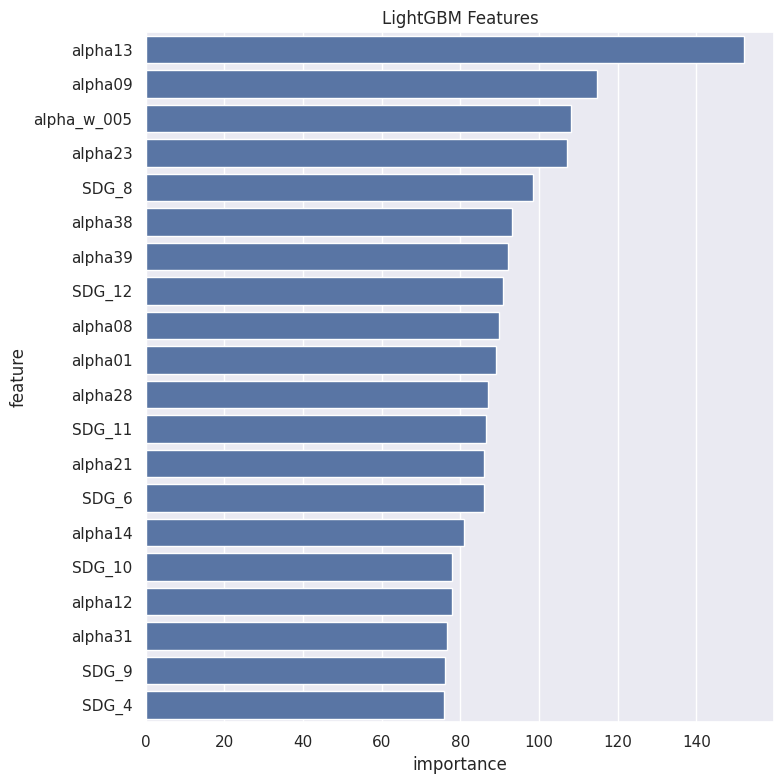

In [67]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature",
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [68]:

test = data.copy()
test = test[test['Timestamp'] > '2018-01-01']
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features])
test['pred'] = pred
date_calc = sorted(test['Timestamp'].unique())


In [69]:
test.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'SDG_1', 'SDG_2', 'SDG_3', 'SDG_4',
       'SDG_5', 'SDG_6', 'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12',
       'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39', 'Company_Name',
       'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up', 'pred'],
      dtype='object')

In [94]:
features[:10]

['alpha01',
 'alpha02',
 'alpha06',
 'alpha07',
 'alpha08',
 'alpha09',
 'alpha10',
 'alpha12',
 'alpha13',
 'alpha14']

In [95]:
test.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha39,Company_Name,GICS Sector,ret,ret1,ret2,open_up,pred,factor_rank,factor_rank_bin
1199,ACGL,2018-01-02,-0.000008,0.000333,-3.244575e-07,-9.547388e-08,-0.000057,0.000120,0.000025,0.000084,...,-0.191936,arch capital group ltd,Financials,1.003507,1.000906,1.003507,1.030464,5.060027,0.888889,9
1200,ACGL,2018-01-03,-0.000008,0.000347,-2.008075e-06,-8.253627e-08,-0.000069,0.000104,0.000021,0.000073,...,-0.193455,arch capital group ltd,Financials,0.999661,1.003734,0.999661,1.032021,5.045415,0.857143,9
1201,ACGL,2018-01-04,-0.000005,0.000392,-3.253231e-06,-8.438338e-08,-0.000071,0.000106,0.000022,0.000075,...,-0.196001,arch capital group ltd,Financials,0.993033,0.996055,0.993033,0.996506,5.056701,0.825397,9
1202,ACGL,2018-01-05,-0.000005,0.000439,-4.275885e-06,-8.942320e-08,-0.000075,0.000113,0.000023,0.000079,...,-0.197342,arch capital group ltd,Financials,0.986653,1.000113,0.986653,1.000339,5.011573,0.523810,6
1203,ACGL,2018-01-08,-0.000005,0.000433,-4.430855e-06,-8.615657e-08,-0.000073,0.000109,0.000022,0.000076,...,-0.197475,arch capital group ltd,Financials,0.983449,0.987100,0.983449,1.007016,5.083238,0.888889,9


In [96]:
test.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'SDG_1', 'SDG_2', 'SDG_3', 'SDG_4',
       'SDG_5', 'SDG_6', 'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12',
       'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39', 'Company_Name',
       'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up', 'pred', 'factor_rank',
       'factor_rank_bin'],
      dtype='object')

In [102]:
df_selected = test[[col for col in features if col in test.columns]]
corr_matrix = df_selected.corr()
corr_matrix

,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,alpha13,alpha14,...,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12
alpha01,1.000000,0.171855,0.754143,0.404559,0.007706,0.270726,0.396242,0.283453,0.012032,0.332621,...,-0.000287,0.021368,0.001108,-0.011921,-0.009273,0.017224,0.013544,0.011699,-0.010179,-0.007049
alpha02,0.171855,1.000000,0.201191,0.465309,-0.686836,0.499151,0.530359,0.596623,0.007059,0.043500,...,-0.000075,-0.011814,0.098247,-0.016145,-0.055993,-0.042952,-0.019778,-0.007999,-0.115899,-0.117765
alpha06,0.754143,0.201191,1.000000,0.512981,0.006992,0.328819,0.495173,0.356959,0.019082,0.302942,...,-0.000142,0.021867,0.000971,-0.013089,-0.012588,0.021271,0.016233,0.012336,-0.012320,-0.008215
alpha07,0.404559,0.465309,0.512981,1.000000,-0.352173,0.718508,0.978260,0.871509,0.067054,0.107462,...,-0.001039,-0.000105,0.022574,-0.009840,-0.015439,-0.000809,0.000396,-0.001043,-0.046252,-0.041705
alpha08,0.007706,-0.686836,0.006992,-0.352173,1.000000,-0.499524,-0.443995,-0.616437,-0.165865,-0.008413,...,-0.001592,0.021044,-0.060771,0.016621,0.042575,0.049017,0.030587,0.003909,0.124418,0.121300
alpha09,0.270726,0.499151,0.328819,0.718508,-0.499524,1.000000,0.794084,0.853058,0.080420,0.056381,...,-0.000857,-0.003060,0.029434,-0.009895,-0.018539,-0.007134,-0.004895,0.002357,-0.066048,-0.057099
alpha10,0.396242,0.530359,0.495173,0.978260,-0.443995,0.794084,1.000000,0.928759,0.096534,0.104465,...,-0.000921,-0.001130,0.026867,-0.011444,-0.019983,-0.004001,-0.001519,-0.000204,-0.062574,-0.056327
alpha12,0.283453,0.596623,0.356959,0.871509,-0.616437,0.853058,0.928759,1.000000,0.175009,0.073907,...,-0.000555,-0.006292,0.035826,-0.014928,-0.030455,-0.014514,-0.011036,-0.000576,-0.094795,-0.084362
alpha13,0.012032,0.007059,0.019082,0.067054,-0.165865,0.080420,0.096534,0.175009,1.000000,0.014906,...,-0.002348,-0.041689,-0.027635,-0.011670,-0.028759,-0.023284,-0.020865,0.007668,-0.106495,-0.102609
alpha14,0.332621,0.043500,0.302942,0.107462,-0.008413,0.056381,0.104465,0.073907,0.014906,1.000000,...,-0.000020,0.005997,-0.002846,-0.006792,-0.003996,0.008288,0.008356,0.007787,-0.004219,-0.004803


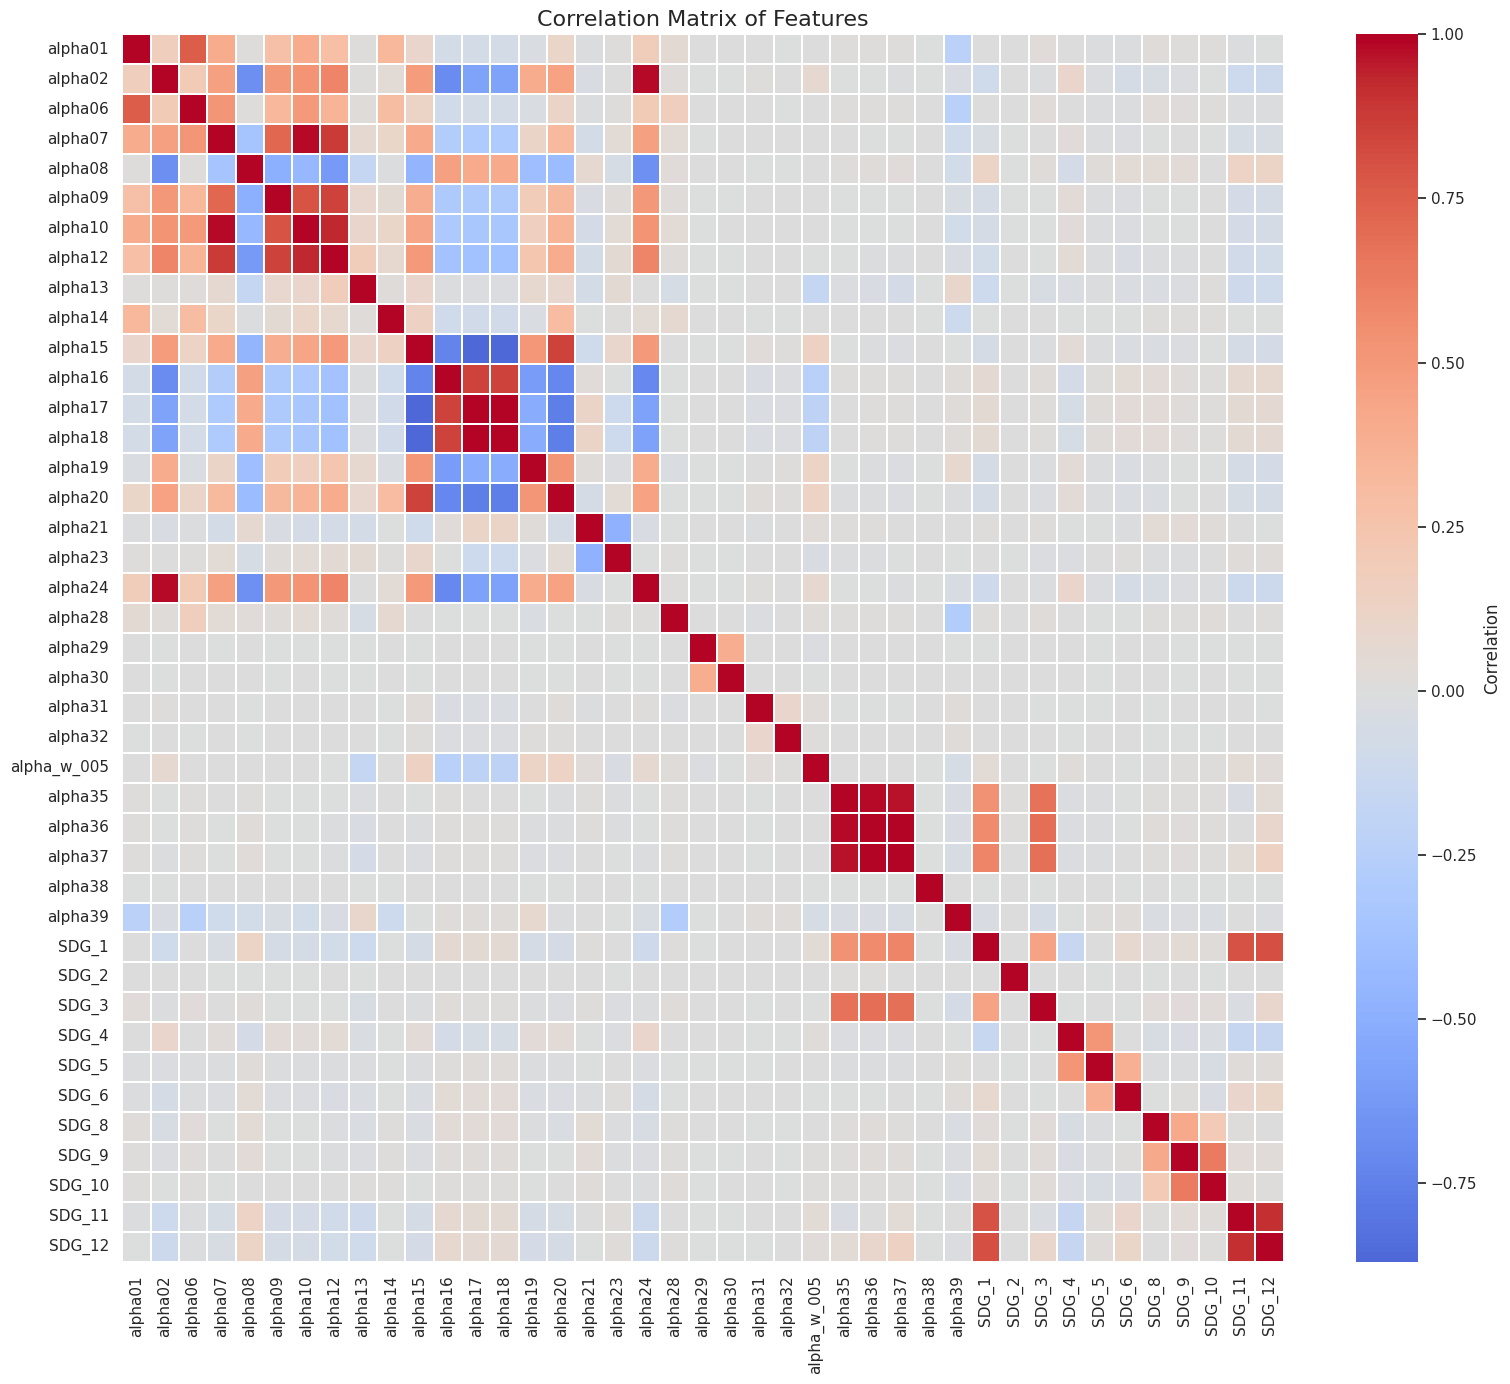

In [103]:
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [104]:
len(features)

41

In [70]:
test['factor_rank'] = test.groupby(['Timestamp', 'GICS Sector']).pred.rank(pct=True,method='dense')

In [71]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [72]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,30108
7,27213
4,26634
9,26055
3,26055
5,26055
6,25476
8,25476
2,25476


<Axes: xlabel='Timestamp'>

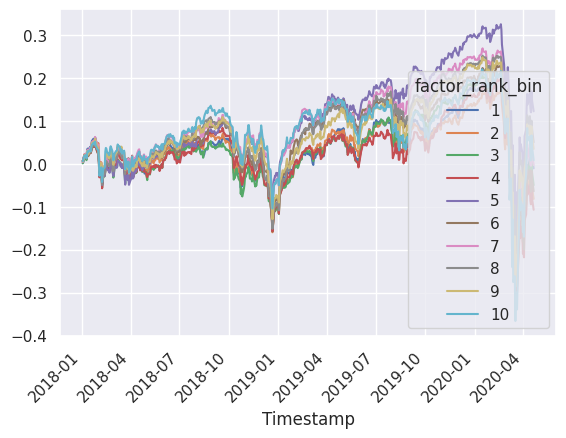

In [73]:
(test.groupby(['factor_rank_bin', \
        'Timestamp']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='Timestamp'>

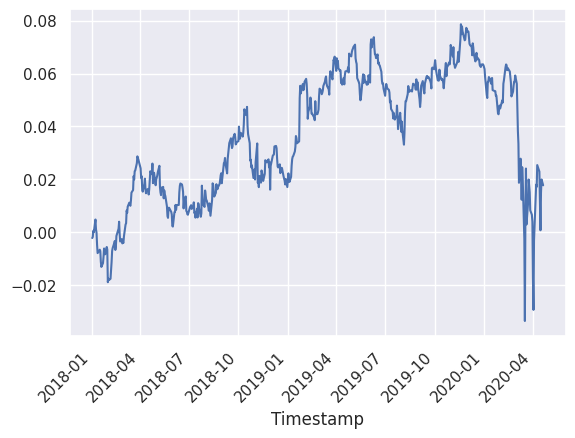

In [74]:

long_ret = (test[(test.factor_rank_bin == 6)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 2)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

<Axes: xlabel='Timestamp'>

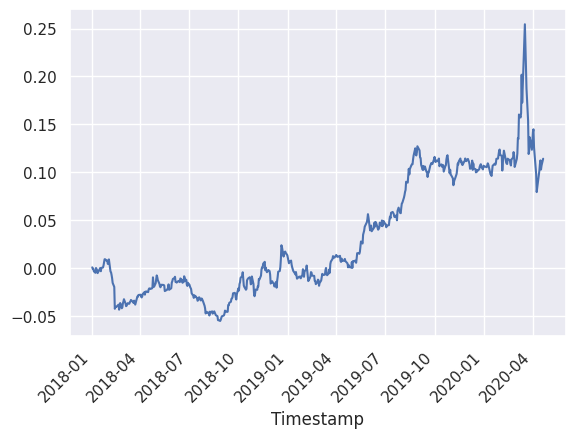

In [80]:

long_ret = (test[(test.factor_rank_bin == 5)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 10)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:

long_ret = (test[(test.factor_rank_bin == 5)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 4)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [77]:
ret_PD = (test.groupby(['factor_rank_bin', 'Timestamp']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [78]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.004344,-0.017558,0.015584,0.552677,-0.339097
1,2,-0.035367,-0.148856,0.014967,0.542314,-0.389988
2,3,-0.021415,-0.088089,0.015314,0.523316,-0.383252
3,4,-0.046396,-0.186128,0.015703,0.535406,-0.416047
4,5,0.053637,0.202504,0.016685,0.544041,-0.359928
5,6,-0.027619,-0.107631,0.016165,0.545769,-0.416783
6,7,-0.001001,-0.003729,0.016905,0.556131,-0.398232
7,8,0.022107,0.078934,0.017642,0.537133,-0.369712
8,9,0.015365,0.054016,0.017919,0.537133,-0.428332
9,10,0.003849,0.012245,0.019804,0.525043,-0.480520


/tmp/ipython-input-99215809.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2018-202 year'}, xlabel='Timestamp'>

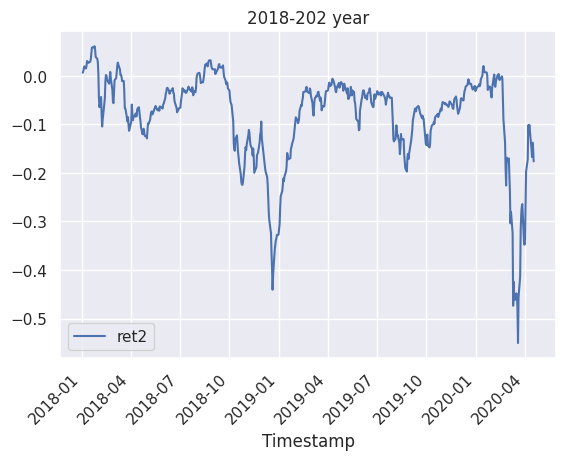

In [106]:

tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 100
tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Timestamp').ret2.mean() - 1.0005)
(ret_pd1.loc['2018-01-01':,] ).cumsum().plot(rot=45, title = '2018-202 year')


In [107]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Timestamp').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [108]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.077054,-0.267783,0.018126,0.507772,-0.575925


#### MLP

In [ ]:
train.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_vwap,alpha33,alpha34,Company_Name,GICS Sector,ret,ret1,ret2,open_up,ret_rank
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.666292e+06,0.220986,NaN,arch capital group ltd,Financials,0.984112,0.997908,0.984112,NaN,0.464789
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.662806e+06,1.754945,NaN,arch capital group ltd,Financials,0.983856,0.991803,0.983856,1.004575,0.316901
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.649176e+06,1.982929,NaN,arch capital group ltd,Financials,0.990031,0.995580,0.990031,1.016145,0.232394
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.641886e+06,0.220986,NaN,arch capital group ltd,Financials,1.007178,0.996911,1.007178,1.016409,0.239437
4,ACGL,2013-04-05,NaN,0.000497,NaN,NaN,NaN,NaN,NaN,NaN,...,1.636814e+06,0.856144,NaN,arch capital group ltd,Financials,1.003883,1.005422,1.003883,1.010070,0.295775


In [ ]:
from numpy.random import seed
# seed(42)
seed(774)
import tensorflow as tf
# tf.random.set_seed(42)
tf.random.set_seed(774)
from tensorflow import keras
import numpy as np
from keras import backend as K

!pip install tf.keras.activations

ERROR: Could not find a version that satisfies the requirement tf.keras.activations (from versions: none)
ERROR: No matching distribution found for tf.keras.activations


In [ ]:
hidden_units = (128, 64, 32)

def base_model():
  num_input = keras.Input(shape=(len(features),), name='num_data')

  out = num_input
  for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

  out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

  model = keras.Model(inputs=[num_input], outputs=[out])
  model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error',
      metrics=['mean_squared_error']
  )
  return model

In [ ]:
model = base_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ num_data (InputLayer)           │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
total_inf = np.isinf(train.select_dtypes(include=[np.number]).values).sum()
total_inf

np.int64(0)

In [ ]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())
test = data.copy()
test = test[test['Timestamp'] > '2018-01-01']
test.replace([np.inf, -np.inf], np.nan,inplace=True)
test[features] = test[features].fillna(train[features].mean())


In [ ]:
from sklearn.preprocessing import QuantileTransformer

train_nn = train[features].copy()
test_nn = test[features].copy()
qt_train = []

for col in features:
  qt = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
  train_nn[col] = qt.fit_transform(train_nn[col].values.reshape(-1,1))
  test_nn[col] = qt.transform(test_nn[col].values.reshape(-1,1))
  qt_train.append(qt)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    # baseline=None,
    restore_best_weights=True
)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    # min_delta=0.0001,
    # cooldown=0,
    # min_lr=0
)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']

oof_predictions = np.zeros(train.shape[0])

for fold, (train_idx, val_idx) in enumerate(enumsplit):
  print('Fold {}'.format(fold + 1))
  X_train, X_val = train_nn.iloc[train_idx], train_nn.iloc[val_idx][features]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

  model = base_model()

  model.fit(
      X_train,
      y_train,
      batch_size=256,
      epochs=100,
      verbose=1,
      validation_data=(X_val, y_val),
      callbacks=[es, plateau],
      shuffle=True,
      # verbose=1
  )
  oof_predictions[val_idx] = model.predict(X_val).reshape(1,-1)[0]
  modellist.append(model)
  print(f"Fold {fold + 1} | RMSPE: {mean_squared_error(y_val, oof_predictions[val_idx])**0.5}")
  corr_score = np.corrcoef(y_val, oof_predictions[val_idx])[0][1]
  print(f"Fold {fold + 1} | corr: {corr_score}")

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f"Overall RMSPE: {rmspe_score}")
corr_score = np.corrcoef(y, oof_predictions)[0][1]
print(f"Overall corr: {corr_score}")


Fold 1
Epoch 1/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 2/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - learning_rate: 0.0010
Epoch 3/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 4/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 5/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0832 - val_mean_squared_error: 0.0832 - learning_rate: 0.0010
Epoch 6/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.08

In [ ]:
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test_nn[features]).reshape(1,-1)[0]
test['pred'] = pred
date_calc = sorted(test['Timestamp'].unique())

8197/8197 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [ ]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [ ]:
test.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,GICS Sector_y,ret_y,ret1_y,ret2_y,open_up_y,Company_Name,ret,ret1,ret2,open_up
0,ACGL,2018-01-02,-0.000008,0.000333,-3.244575e-07,-9.547388e-08,-0.000057,0.000120,0.000025,0.000084,...,Financials,1.003507,1.000906,1.003507,1.030464,arch capital group ltd,1.003507,1.000906,1.003507,1.030464
1,ACGL,2018-01-03,-0.000008,0.000347,-2.008075e-06,-8.253627e-08,-0.000069,0.000104,0.000021,0.000073,...,Financials,0.999661,1.003734,0.999661,1.032021,arch capital group ltd,0.999661,1.003734,0.999661,1.032021
2,ACGL,2018-01-04,-0.000005,0.000392,-3.253231e-06,-8.438338e-08,-0.000071,0.000106,0.000022,0.000075,...,Financials,0.993033,0.996055,0.993033,0.996506,arch capital group ltd,0.993033,0.996055,0.993033,0.996506
3,ACGL,2018-01-05,-0.000005,0.000439,-4.275885e-06,-8.942320e-08,-0.000075,0.000113,0.000023,0.000079,...,Financials,0.986653,1.000113,0.986653,1.000339,arch capital group ltd,0.986653,1.000113,0.986653,1.000339
4,ACGL,2018-01-08,-0.000005,0.000433,-4.430855e-06,-8.615657e-08,-0.000073,0.000109,0.000022,0.000076,...,Financials,0.983449,0.987100,0.983449,1.007016,arch capital group ltd,0.983449,0.987100,0.983449,1.007016


In [ ]:
test.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34',
       'Company_Name_x', 'GICS Sector_x', 'ret_x', 'ret1_x', 'ret2_x',
       'open_up_x', 'pred', 'Company_Name_y', 'GICS Sector_y', 'ret_y',
       'ret1_y', 'ret2_y', 'open_up_y', 'Company_Name', 'ret', 'ret1', 'ret2',
       'open_up'],
      dtype='object')

In [ ]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [ ]:
# test = pd.merge(test, df[['Timestamp', 'Ticker', 'Company_Name','GICS Sector', 'ret', 'ret1', 'ret2', 'open_up']], how='left', on=['Timestamp', 'Ticker'])
test['factor_rank'] = test.groupby(['Timestamp','GICS Sector_y']).pred.rank(pct=True,method='dense')

def fun(x):
  if np.isnan(x):
    return np.nan
  else:
    return min(10, int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,30108
7,27213
4,26634
3,26055
9,26055
5,26055
8,25476
6,25476
2,25476


<Axes: xlabel='Timestamp'>

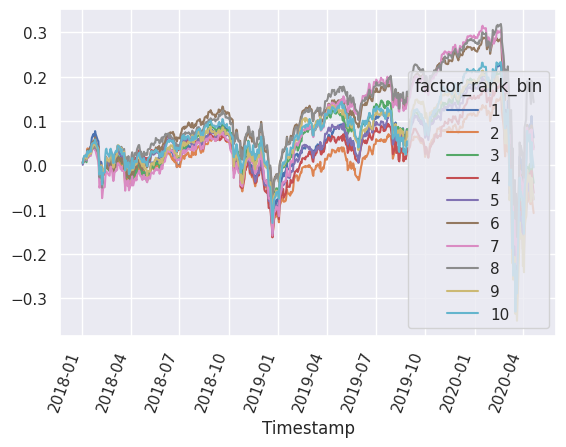

In [ ]:
(test.groupby(['factor_rank_bin', \
        'Timestamp']).ret1.mean()-1).unstack().T.cumsum().plot(rot=70,grid=True)

<Axes: xlabel='Timestamp'>

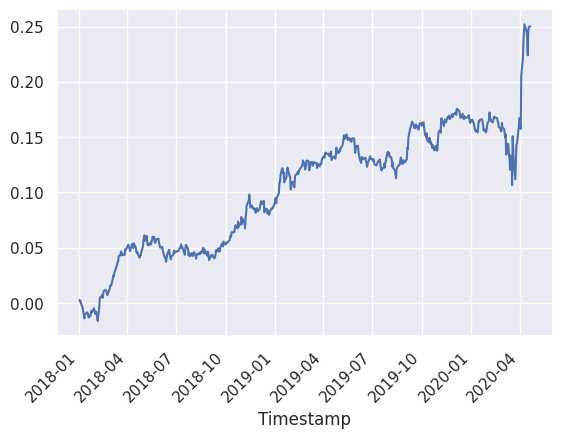

In [ ]:
long_ret = (test[(test.factor_rank_bin == 8)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 2)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:
ret_PD = (test.groupby(['factor_rank_bin', 'Timestamp']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [ ]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.027471,0.113465,0.015252,0.550950,-0.336964
1,2,-0.046929,-0.190248,0.015539,0.550950,-0.384115
2,3,-0.017214,-0.070470,0.015388,0.535406,-0.380153
3,4,-0.027003,-0.107029,0.015893,0.544041,-0.390841
4,5,-0.033461,-0.130097,0.016202,0.547496,-0.414359
5,6,0.017581,0.066783,0.016583,0.550950,-0.369145
6,7,0.015813,0.057857,0.017217,0.535406,-0.408974
7,8,0.062173,0.225954,0.017333,0.542314,-0.364377
8,9,-0.033487,-0.115392,0.018281,0.531952,-0.464695
9,10,-0.001939,-0.006499,0.018791,0.516408,-0.456613


In [ ]:
test.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,ret1_y,ret2_y,open_up_y,Company_Name,ret,ret1,ret2,open_up,factor_rank,factor_rank_bin
0,ACGL,2018-01-02,-0.000008,0.000333,-3.244575e-07,-9.547388e-08,-0.000057,0.000120,0.000025,0.000084,...,1.000906,1.003507,1.030464,arch capital group ltd,1.003507,1.000906,1.003507,1.030464,0.682540,7
1,ACGL,2018-01-03,-0.000008,0.000347,-2.008075e-06,-8.253627e-08,-0.000069,0.000104,0.000021,0.000073,...,1.003734,0.999661,1.032021,arch capital group ltd,0.999661,1.003734,0.999661,1.032021,0.793651,8
2,ACGL,2018-01-04,-0.000005,0.000392,-3.253231e-06,-8.438338e-08,-0.000071,0.000106,0.000022,0.000075,...,0.996055,0.993033,0.996506,arch capital group ltd,0.993033,0.996055,0.993033,0.996506,0.888889,9
3,ACGL,2018-01-05,-0.000005,0.000439,-4.275885e-06,-8.942320e-08,-0.000075,0.000113,0.000023,0.000079,...,1.000113,0.986653,1.000339,arch capital group ltd,0.986653,1.000113,0.986653,1.000339,0.825397,9
4,ACGL,2018-01-08,-0.000005,0.000433,-4.430855e-06,-8.615657e-08,-0.000073,0.000109,0.000022,0.000076,...,0.987100,0.983449,1.007016,arch capital group ltd,0.983449,0.987100,0.983449,1.007016,0.793651,8


/tmp/ipython-input-2850261884.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2018-2020 year'}, xlabel='Timestamp'>

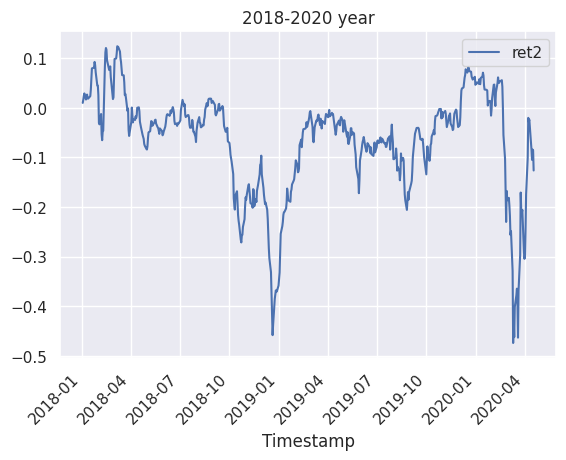

In [ ]:
tmp = test.copy()
# tmp = tmp[~tmp.close.isna()].reset_index(drop=True)
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Timestamp').ret2.mean() - 1.0005)
(ret_pd1.loc['2018-01-01':,] ).cumsum().plot(rot=45, title = '2018-2020 year')

In [ ]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Timestamp').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [ ]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.05516,-0.161526,0.021512,0.516408,-0.532686


#### Transformer

In [24]:
train = data.copy()
# train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('Timestamp').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

# from sklearn.model_selection import KFold,GroupKFold,train_test_split

# kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# enumsplit = []
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind, val_ind])
# enumsplit

In [25]:
train.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'SDG_1', 'SDG_2', 'SDG_3', 'SDG_4',
       'SDG_5', 'SDG_6', 'SDG_8', 'SDG_9', 'SDG_10', 'SDG_11', 'SDG_12',
       'alpha35', 'alpha36', 'alpha37', 'alpha38', 'alpha39', 'Company_Name',
       'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up', 'ret_rank'],
      dtype='object')

In [28]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())

In [29]:
y = train['ret_rank']

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = train.copy()
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [31]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df, verbose=True)

Memory usage after optimization is: 94.19 MB
Decreased by 69.0%


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796534 entries, 0 to 796533
Data columns (total 50 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Ticker        796534 non-null  object        
 1   Timestamp     796534 non-null  datetime64[ns]
 2   alpha01       796534 non-null  float16       
 3   alpha02       796534 non-null  float16       
 4   alpha06       796534 non-null  float16       
 5   alpha07       796534 non-null  float16       
 6   alpha08       796534 non-null  float16       
 7   alpha09       796534 non-null  float16       
 8   alpha10       796534 non-null  float16       
 9   alpha12       796534 non-null  float16       
 10  alpha13       796534 non-null  float16       
 11  alpha14       796534 non-null  float16       
 12  alpha15       796534 non-null  float16       
 13  alpha16       796534 non-null  float16       
 14  alpha17       796534 non-null  float16       
 15  alpha18       796

In [127]:
def create_time_series(df, n_steps):
  X, y, Xmeta = [], [], []
  for tmp in tqdm(df.groupby('Ticker')):
    ts_code = tmp[0]
    stock_df = tmp[1]
    for i in range(n_steps-1, len(stock_df)-1):
      X.append(stock_df[features_columns].iloc[i-n_steps+1:i+1].values)
      y.append(stock_df['ret_rank'].iloc[i])
      Xmeta.append(([ts_code, stock_df['Timestamp'].iloc[i]]))
  return np.array(X), np.array(y), np.array(Xmeta)

features_columns = features
n_steps = 10
X, y, Xmeta = create_time_series(df, n_steps)

100%|██████████| 453/453 [23:13<00:00,  3.08s/it]


In [128]:
import pickle
with open('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/ts.pkl', 'wb') as f:
    pickle.dump((X, y, Xmeta), f)

In [35]:
with open('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/ts.pkl', 'rb') as f:
  (X, y, Xmeta)  = pickle.load(f)

In [122]:
# tmp = df.groupby('Ticker').get_group('ACGL')
# tmp.head()
# X, y, Xmeta = [], [], []
# ts_code = "ACGL"
# stock_df = tmp
# for i in range(10-1, len(stock_df)-1):
#     X.append(stock_df[features_columns].iloc[i-n_steps+1:i+1].values)
#     y.append(stock_df['ret_rank'].iloc[i])
#     Xmeta.append(([ts_code, stock_df['Timestamp'].iloc[i]]))
# stock_df[features_columns].iloc[9-n_steps+1:9+1].values

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha37,alpha38,alpha39,Company_Name,GICS Sector,ret,ret1,ret2,open_up,ret_rank
0,ACGL,2013-04-01,0.0,-0.000000,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,arch capital group ltd,Financials,0.983887,0.998047,0.983887,NaN,0.464844
1,ACGL,2013-04-02,0.0,-0.000000,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,arch capital group ltd,Financials,0.983887,0.991699,0.983887,1.004883,0.316895
2,ACGL,2013-04-03,0.0,-0.000000,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,arch capital group ltd,Financials,0.990234,0.995605,0.990234,1.016602,0.232422
3,ACGL,2013-04-04,0.0,-0.000000,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,arch capital group ltd,Financials,1.006836,0.997070,1.006836,1.016602,0.239380
4,ACGL,2013-04-05,0.0,-0.453125,0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,-0.0,0.0,arch capital group ltd,Financials,1.003906,1.005859,1.003906,1.009766,0.295654


In [36]:
Xmetapd = pd.DataFrame(Xmeta, columns = ['Ticker', 'Timestamp'])
train_index = Xmetapd[Xmetapd['Timestamp'] < '2020-01-01'].index
test_index = Xmetapd[Xmetapd['Timestamp'] >= '2020-01-01'].index

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Embedding,GlobalAveragePooling1D

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = LayerNormalization(epsilon=1e-6)(inputs)
  x = MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout
  )(x, x)
  x = Dropout(dropout)(x)
  res = x + inputs

  x = LayerNormalization(epsilon=1e-6)(res)
  x = Dense(ff_dim, activation="relu")(x)
  x = Dropout(dropout)(x)
  x = Dense(inputs.shape[-1])(x)
  return x + res

def build_model(sequence_length, feature_size, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
  inputs = Input(shape=(sequence_length, feature_size))
  x = inputs
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  x = GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = Dense(dim, activation="relu")(x)
    x = Dropout(mlp_dropout)(x)
  outputs = Dense(1)(x)
  return Model(inputs, outputs)

sequence_length = 10
feature_size = len(features)
model = build_model(sequence_length, feature_size)
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mean_squared_error"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 41)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 41)    │         82 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 41)    │    171,049 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 41)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 41)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 41)    │         82 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 4)     │        168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 4)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 41)    │        205 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 41)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 41)    │         82 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 41)    │    171,049 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 41)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 41)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 41)    │         82 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 4)     │        168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 4)     │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 41)    │        205 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 41)    │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 687,881 (2.62 MB)

 Trainable params: 687,881 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.fit(X_train, y_train, epochs=2, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/2
189734/189734 ━━━━━━━━━━━━━━━━━━━━ 1217s 6ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.0874 - val_mean_squared_error: 0.0874
Epoch 2/2
189734/189734 ━━━━━━━━━━━━━━━━━━━━ 1073s 6ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0837 - val_mean_squared_error: 0.0837


In [39]:
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Mean Squared Error: 0.08374947309494019


In [40]:
test = Xmetapd[Xmetapd['Timestamp'] >= '2020-01-01']
test.head()

,Ticker,Timestamp
1693,ACGL,2020-01-02
1694,ACGL,2020-01-03
1695,ACGL,2020-01-06
1696,ACGL,2020-01-07
1697,ACGL,2020-01-08


In [41]:
test['pred'] = predictions

/tmp/ipython-input-1067349374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = predictions


In [56]:
# test.pred.value_counts()

In [44]:
data_calc = sorted(test['Timestamp'].unique())

In [46]:
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Ticker,Timestamp,pred,Company_Name,GICS Sector,ret,ret1,ret2,open_up
0,ACGL,2020-01-02,0.501526,arch capital group ltd,Financials,1.008789,0.999023,1.008789,0.984375
1,ACGL,2020-01-03,0.501526,arch capital group ltd,Financials,0.994141,1.003906,0.994141,0.992188
2,ACGL,2020-01-06,0.501526,arch capital group ltd,Financials,0.980469,0.991699,0.980469,0.991699
3,ACGL,2020-01-07,0.501526,arch capital group ltd,Financials,1.010742,0.990234,1.010742,1.005859
4,ACGL,2020-01-08,0.501526,arch capital group ltd,Financials,1.016602,1.020508,1.016602,1.020508


In [75]:
# test = pd.merge(test, df[['Timestamp', 'Ticker', 'Company_Name','GICS Sector', 'ret', 'ret1', 'ret2', 'open_up']], how='left', on=['Timestamp', 'Ticker'])
test['factor_rank'] = test.groupby(['Timestamp','GICS Sector']).pred.rank(pct=True,method='dense')

In [76]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [77]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,31646
6,1423


In [70]:
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Ticker,Timestamp,pred,Company_Name_x,GICS Sector_x,ret_x,ret1_x,ret2_x,open_up_x,Company_Name_y,...,ret2_y,open_up_y,Company_Name,GICS Sector,ret,ret1,ret2,open_up,factor_rank,factor_rank_bin
0,ACGL,2020-01-02,0.501526,arch capital group ltd,Financials,1.008789,0.999023,1.008789,0.984375,arch capital group ltd,...,1.008789,0.984375,arch capital group ltd,Financials,1.008789,0.999023,1.008789,0.984375,1.0,10
1,ACGL,2020-01-03,0.501526,arch capital group ltd,Financials,0.994141,1.003906,0.994141,0.992188,arch capital group ltd,...,0.994141,0.992188,arch capital group ltd,Financials,0.994141,1.003906,0.994141,0.992188,1.0,10
2,ACGL,2020-01-06,0.501526,arch capital group ltd,Financials,0.980469,0.991699,0.980469,0.991699,arch capital group ltd,...,0.980469,0.991699,arch capital group ltd,Financials,0.980469,0.991699,0.980469,0.991699,1.0,10
3,ACGL,2020-01-07,0.501526,arch capital group ltd,Financials,1.010742,0.990234,1.010742,1.005859,arch capital group ltd,...,1.010742,1.005859,arch capital group ltd,Financials,1.010742,0.990234,1.010742,1.005859,0.5,6
4,ACGL,2020-01-08,0.501526,arch capital group ltd,Financials,1.016602,1.020508,1.016602,1.020508,arch capital group ltd,...,1.016602,1.020508,arch capital group ltd,Financials,1.016602,1.020508,1.016602,1.020508,1.0,10


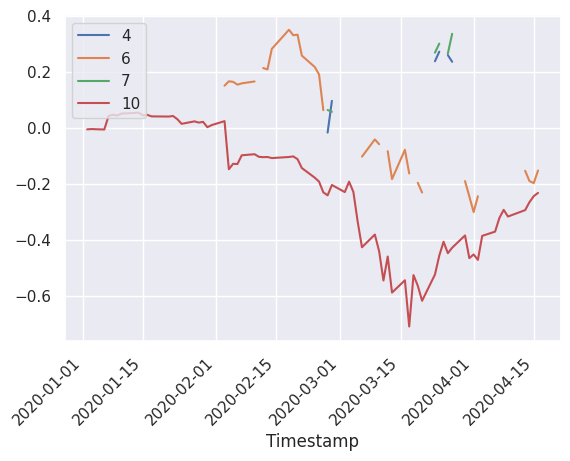

In [69]:
(test.groupby(['factor_rank_bin', \
               'Timestamp']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)
plt.legend(loc='upper left')

<Axes: xlabel='Timestamp'>

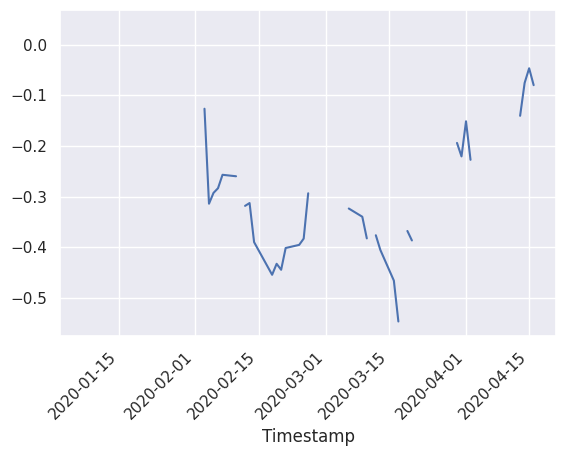

In [71]:
long_ret = (test[(test.factor_rank_bin == 10)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 6)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

/tmp/ipython-input-99215809.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2018-202 year'}, xlabel='Timestamp'>

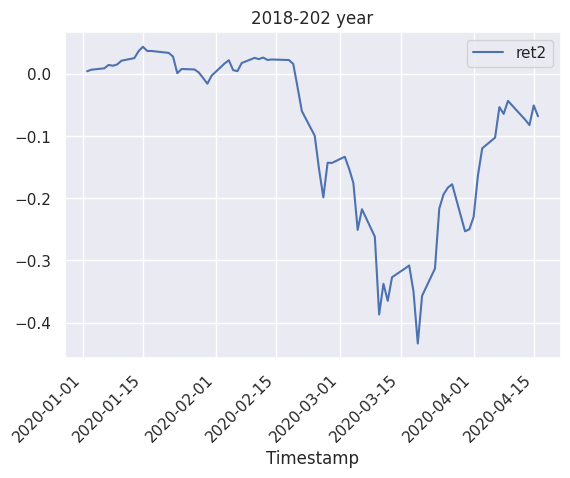

In [73]:

tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 100
tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Timestamp').ret2.mean() - 1.0005)
(ret_pd1.loc['2018-01-01':,] ).cumsum().plot(rot=45, title = '2018-202 year')
